    Survey Date      Total    Total Live Salmon    Total Dead    Live Chum    Live Coho    Dead Chum    Dead Coho
--  -------------  -------  -------------------  ------------  -----------  -----------  -----------  -----------
 0  2020-10-15           2                    0             1            0            0            0            1
 1  2020-10-28           5                    2             3            2            0            3            0
 2  2020-10-29           4                    4             0            4            0            0            0
 3  2020-10-31          13                    8             2            8            0            1            1
 4  2020-11-04          36                   28             5           28            0            2            3
 5  2020-11-07          46                   39             2           39            0            2            0
 6  2020-11-11          63                   41            18           40            1 

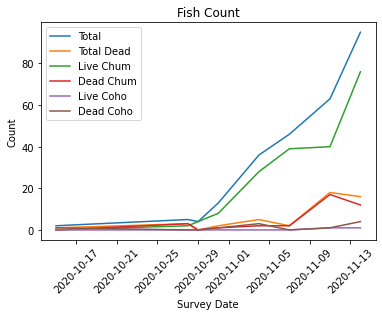

In [40]:
import requests, json, datetime, matplotlib.pyplot as plt, plotly.express as px, pandas as pd

def getEntries(uri):
    request = requests.get(url = uri)
    df = pd.DataFrame(pd.json_normalize(request.json()['data']['entries']))
    while request.json()['links']['next'] is not None:
        nextURL = request.json()['links']['next']
        request = requests.get(url = nextURL)
        df = df.append(pd.json_normalize(request.json()['data']['entries']))
    return df

def addStats(survey, salmonDf):
    surveyUUID = survey['ec5_uuid']
    todaySalmonDf = salmonDf[salmonDf['ec5_parent_uuid'] == surveyUUID] 
    deadChum = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Chum') & (todaySalmonDf['16_Status'] == 'Dead'))].shape[0]) 
    deadCoho = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Coho') & (todaySalmonDf['16_Status'] == 'Dead'))].shape[0])
    liveChum = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Chum') & (todaySalmonDf['16_Status'] == 'Live'))].shape[0])
    liveCoho = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Coho') & (todaySalmonDf['16_Status'] == 'Live'))].shape[0])
    totalDead = todaySalmonDf.loc[(todaySalmonDf['16_Status'] == 'Dead')].shape[0]
    totalLiveSalmon = liveChum + liveCoho
    total = (todaySalmonDf.shape[0])
    statsRow = pd.Series({'Survey Date': datetime.datetime.strptime(survey['1_Survey_Date'], '%m/%d/%Y').date(), 'Dead Chum': deadChum, 'Dead Coho': deadCoho, 'Live Chum': liveChum, 'Live Coho': liveCoho, 'Total Dead': totalDead, 'Total Live Salmon': totalLiveSalmon, 'Total': total})
    global statsDf
    statsDf = statsDf.append(statsRow, ignore_index = True)

def printYearlyTotals(statsDf):
    max = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).max()
    idxmax = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).idxmax()
    print('Yearly salmon total is:', int(max))
    print('Yearly total of Chum is:', int((statsDf['Dead Chum to Date']+statsDf['Live Chum']).max()))
    print('Yearly total of Coho is:', int((statsDf['Dead Coho to Date']+statsDf['Live Coho']).max()))
    print('Calculated based on date:', statsDf.iloc[idxmax]['Survey Date'])
    print('Based on total dead count:', int(statsDf.iloc[idxmax]['Dead to Date']), '|', 'plus total live count:', int(statsDf.iloc[idxmax]['Total Live Salmon']))
    
pd.set_option('display.precision', 0)
salmonFormURI = 'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f509867795'
surveyFormURI = 'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f454667a28'
salmonDf = getEntries(salmonFormURI)
surveyDf = getEntries(surveyFormURI)
statsDf = pd.DataFrame()
columnOrder =  ['Survey Date', 'Total', 'Total Live Salmon', 'Total Dead', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho']
surveyDf.apply(addStats, axis=1, args=[salmonDf])
statsDf= statsDf.groupby(['Survey Date']).sum().reset_index()
statsDf = statsDf.sort_values(by=['Survey Date'])[columnOrder]
kwargs = {'Dead to Date' : statsDf['Total Dead'].cumsum(), 'Dead Chum to Date' : statsDf['Dead Chum'].cumsum(), 'Dead Coho to Date' : statsDf['Dead Coho'].cumsum()}
statsDf = statsDf.assign(**kwargs)
print(statsDf[['Survey Date', 'Total', 'Total Live Salmon', 'Total Dead', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho']].to_markdown(tablefmt='simple'))
printYearlyTotals(statsDf)
plot = statsDf.plot(ylabel = 'Count', title = 'Fish Count', rot=45, y=['Total', 'Total Dead', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho'], x='Survey Date')
fig = px.density_mapbox(salmonDf, lat='15_Location.latitude', lon='15_Location.longitude', radius=15,
                        center=dict(lat=47.71157, lon=-122.3759), zoom=15, hover_name = 'title', hover_data = ['15_Location.accuracy'],
                        mapbox_style='stamen-terrain', title='Fish Heat Map')
fig.layout.coloraxis.showscale = False
fig.show()